In [51]:
%%capture
!pip install eli5

## Capstone Project 2: 재고 관리를 위한 단기(6개월) 수요 예측 모델 생성

### Part 3. XGBoost 모델

### 사용 데이터셋

> Forecasts for Product Demand: Make Accurate Forecasts for Thousands of Different Products
> - FelixZhao. kaggle. https://www.kaggle.com/felixzhao/productdemandforecasting
> - License: GPL 2

### 1. 데이터 준비

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib 화질 설정
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [2]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [3]:
# 데이터 불러오기
df = pd.read_csv('Historical_Data_After.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head(3)

,product_code,product_category,date,order_demand,year,month,quarter,YM,YQ
0,993,28,2012-01-19,100,2012,1,1,2012-01,2012-1
1,993,28,2012-02-08,100,2012,2,1,2012-02,2012-1
2,993,28,2012-02-22,100,2012,2,1,2012-02,2012-1


In [4]:
day_list = []

def make_month_day(month, last_day):
    global day_list

    # 월 표기를 01로 변경
    if len(str(month)) == 1:
        month = '0'+str(month)

    # 일 표기 추가
    for day in range(1, last_day):
        if len(str(day)) == 1:
            day = '0'+str(day)

        temp_date = year + '-' + str(month) + '-' + str(day)
        day_list.append(temp_date)
        
for year in ['2012', '2013', '2014', '2015', '2016']:
    for month in range(1, 13):
        
        # 31일까지 있는 달
        if month in [1, 3, 5, 7, 8, 10, 12]:
            make_month_day(month, 32)
        
        # 30일까지 있는 달
        elif month in [4, 6, 9, 11]:
            make_month_day(month, 31)
                
        else:
            month = '02'
            
            # 29일까지 있는 달
            if (year == '2012') or (year == '2016'):
                make_month_day(month, 30)
                
            # 28일까지 있는 달
            else:
                make_month_day(month, 29)

day_list = set(day_list)

print(len(day_list))

1827


In [5]:
temp_cat = pd.pivot_table(df, values='order_demand', index=['date'], columns=['product_category'], aggfunc=np.sum).fillna(0)
temp_cat.columns = list(temp_cat.columns)
temp_cat.head(3)

,1,3,5,6,7,8,9,10,11,13,15,17,18,19,20,21,22,23,24,26,28,29,30,31,32,33
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-02,107.0,0.0,3500.0,13000.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,653950.0,0.0,100.0,0.0,0.0,55.0,0.0,0.0,0.0,9000.0,0.0,540.0,0.0
2012-01-03,25.0,0.0,33600.0,72400.0,6952.0,0.0,1576.0,0.0,151.0,0.0,208.0,0.0,19.0,1499806.0,1000.0,917.0,62.0,170.0,1058.0,114.0,8053.0,0.0,18600.0,10.0,36.0,0.0


In [6]:
# 빈 날짜 목록 생성
temp_cat_index = set(temp_cat.index)
need = day_list - temp_cat_index
print(len(need))

# 빈 날짜의 수요량은 0로 채우기
for idx in list(need):
    temp_cat.loc[idx] = 0

temp_cat = temp_cat.sort_index()

print(temp_cat.shape)

147
(1827, 26)


In [7]:
temp_product = pd.pivot_table(df, values='order_demand', index=['date'], columns=['product_code'], aggfunc=np.sum).fillna(0)
temp_product.columns = list(temp_product.columns)
temp_product.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,2132,2133,2134,2135,2136,2137,2138,2139,2140,2141,2142,2143,2144,2145,2146,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0
2012-01-03,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,153.0,0.0,0.0,20.0,0.0,0.0,1164.0,200.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
# 빈 날짜 목록 생성
temp_product_index = set(temp_product.index)
need = day_list - temp_product_index
print(len(need))

# 빈 날짜의 수요량은 0로 채우기
for idx in list(need):
    temp_product.loc[idx] = 0

temp_product = temp_product.sort_index()

print(temp_product.shape)

147
(1827, 2125)


In [9]:
# 카테고리 19만 선택
cat_19 = temp_cat[[19]]
cat_19 = cat_19.reset_index()
cat_19.columns = ['date', 'order_demand']

print(cat_19.shape)
cat_19.head()

(1827, 2)


,date,order_demand
0,2012-01-01,0.0
1,2012-01-02,653950.0
2,2012-01-03,1499806.0
3,2012-01-04,626100.0
4,2012-01-05,7458199.0


### 2. 모델 생성

In [10]:
# date에서 year, month, day, quarter, day of week, week of year 추출
time_19 = cat_19.reset_index(drop=True)

time_19['date'] = pd.to_datetime(time_19['date'])

time_19['year'] = time_19['date'].dt.year
time_19['month'] = time_19['date'].dt.month
time_19['day'] = time_19['date'].dt.day
time_19['quarter'] = time_19['date'].dt.quarter
time_19['day_of_week'] = time_19['date'].dt.dayofweek
time_19['week_of_year'] = time_19['date'].dt.isocalendar().week
time_19['week_of_year'] = time_19['week_of_year'].astype(int)

In [11]:
# train, validation data set 생성
train = time_19[time_19['date'] < '2016-07-01']
val = time_19[time_19['date'] >= '2016-07-01']
print(train.shape, val.shape)

(1643, 8) (184, 8)


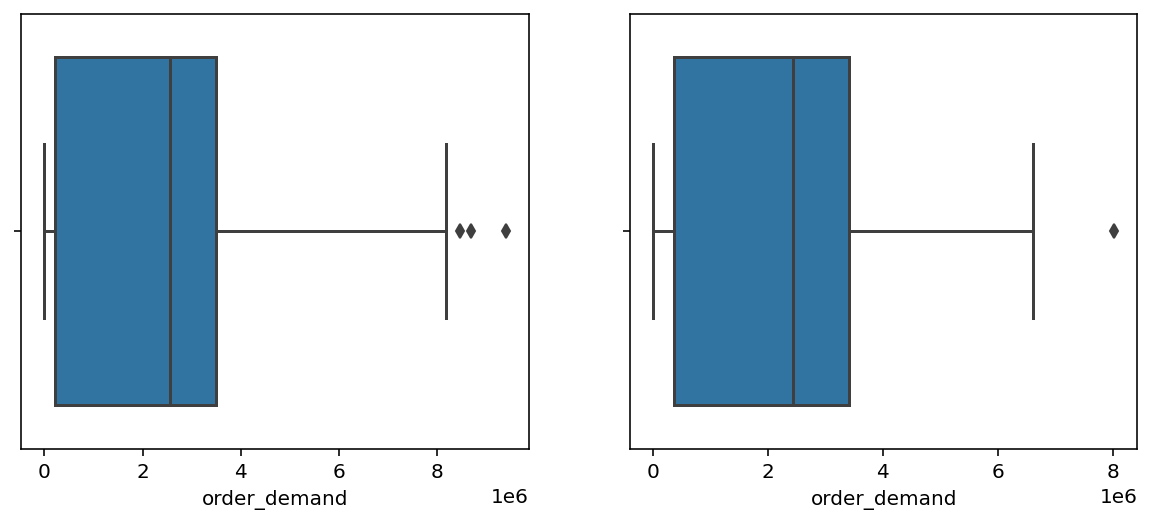

In [12]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
sns.boxplot(data=train, x='order_demand')

plt.subplot(122)
sns.boxplot(data=val, x='order_demand');

train data set과 validation data set의 분포와 범위가 비슷한 것을 확인할 수 있다.

In [13]:
# Feature와 Target 분리
target = 'order_demand'
features = train.drop([target, 'date'], axis=1).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1643, 6) (1643,)
(184, 6) (184,)


In [14]:
# 확인
X_train.head(3)

,year,month,day,quarter,day_of_week,week_of_year
0,2012,1,1,1,6,52
1,2012,1,2,1,0,1
2,2012,1,3,1,1,1


In [15]:
X_val.head(3)

,year,month,day,quarter,day_of_week,week_of_year
1643,2016,7,1,3,4,26
1644,2016,7,2,3,5,26
1645,2016,7,3,3,6,26


#### a. 시간 정보를 feature로 사용

EDA를 했을때는 시간, 계절에 따른 주기가 없어보이긴 했지만, 각 연도, 월, 일, 분기, 요일, 그리고 몇 주차인지를 feature로 사용해서 모델을 만들어보았다.

##### 1) 전체 기간 데이터 사용

In [16]:
# 파이프라인 생성 및 학습
xgb_basic = make_pipeline(
    SimpleImputer(),
    RobustScaler(),
    XGBRegressor(random_state=1,
                 n_jobs=-1,
                 objective='reg:squarederror',
                 max_depth=5,
                 learning_rate=0.2))

xgb_basic.fit(X_train, y_train);

In [17]:
# 예측
y_pred = xgb_basic.predict(X_val)

# 결과 확인

print('mae:  ', mae(y_val, y_pred))
print('rmse: ', np.sqrt(mse(y_val, y_pred)))

mae:   715350.4879946501
rmse:  1019236.9059581758


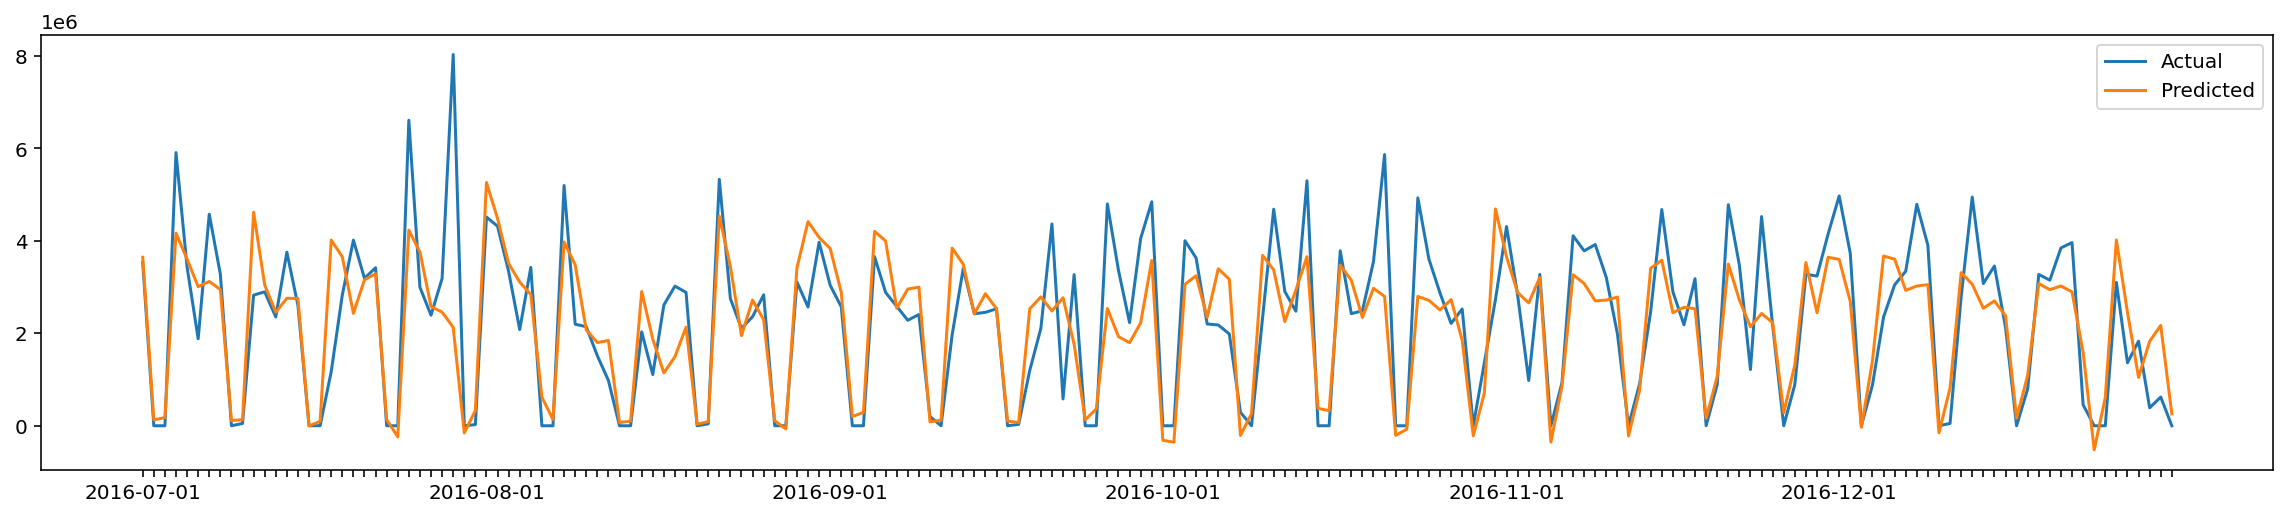

In [18]:
plt.figure(figsize=(20, 4))
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], cat_19[cat_19['date'] >= '2016-07-01']['order_demand'], label='Actual')
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], y_pred, label='Predicted')

labels = [item if item[-2:] == '01' else '' for item in sorted(day_list) if ((item[:4] == '2016') and (item[5:7] >= '07'))]
plt.xticks(cat_19[cat_19['date'] >= '2016-07-01']['date'], labels)
plt.legend()
plt.show();

위 그림은 2012년에서 2016년 6월까지의 데이터를 모두 학습에 사용한 모델의 예측 결과를 시각화 한 것이다.

##### 2) 2015년 데이터만 사용

In [19]:
# 파이프라인 생성 및 학습
xgb_basic = make_pipeline(
    SimpleImputer(),
    RobustScaler(),
    XGBRegressor(random_state=1,
                 n_jobs=-1,
                 objective='reg:squarederror',
                 max_depth=5,
                 learning_rate=0.2))

xgb_basic.fit(X_train[X_train['year']==2015], y_train[X_train[X_train['year']==2015].index]);

In [20]:
# 예측
y_pred = xgb_basic.predict(X_val)

# 결과 확인
print('mae:  ', mae(y_val, y_pred))
print('rmse: ', np.sqrt(mse(y_val, y_pred)))

mae:   826738.7772827148
rmse:  1184192.3724758527


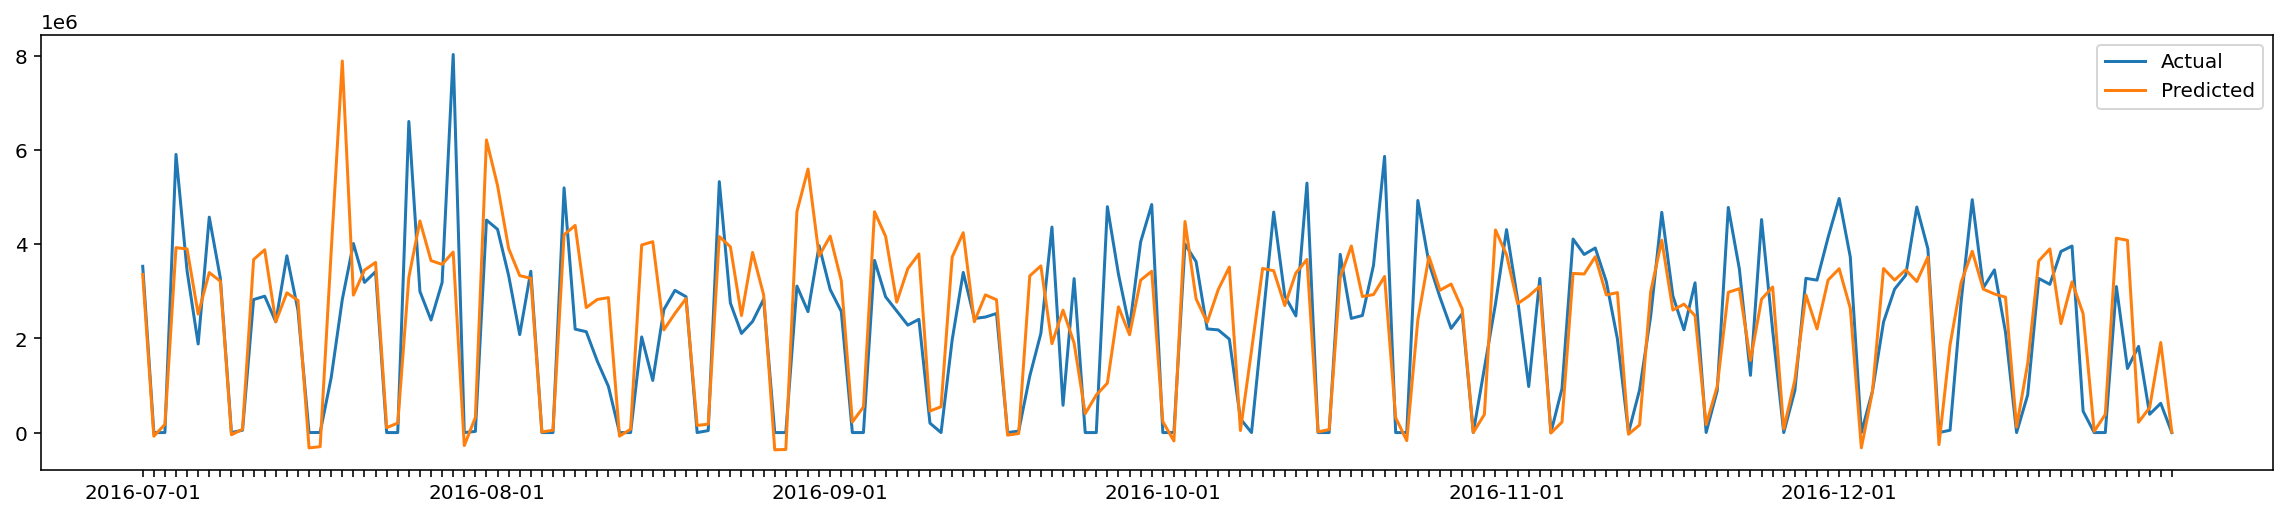

In [21]:
plt.figure(figsize=(20, 4))
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], cat_19[cat_19['date'] >= '2016-07-01']['order_demand'], label='Actual')
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], y_pred, label='Predicted')

labels = [item if item[-2:] == '01' else '' for item in sorted(day_list) if ((item[:4] == '2016') and (item[5:7] >= '07'))]
plt.xticks(cat_19[cat_19['date'] >= '2016-07-01']['date'], labels)
plt.legend()
plt.show();

위 그림은 2015년 데이터부터 학습에 사용한 모델의 예측 결과를 시각화한 것이다.

#### b. Lag 방식 사용

In [22]:
# lag 생성
for num in range(1, 41):
  cat_19['t-'+str(num)] = cat_19['order_demand'].shift(num)

In [23]:
# 다 nan인 row 제거
cat_19 = cat_19.drop(0).reset_index(drop=True)

In [24]:
# train, validation data set 생성
train_lag = cat_19[cat_19['date'] < '2016-07-01']
val_lag = cat_19[cat_19['date'] >= '2016-07-01']

In [25]:
# 2015년만 선택
train_lag_2015 = train_lag[train_lag['date'] >= '2015-01-01']

In [26]:
# feature, target 분리
X_train_lag = train_lag.drop(['date', 'order_demand'], axis=1)
y_train_lag = train_lag['order_demand']

X_train_lag_2015 = train_lag_2015.drop(['date', 'order_demand'], axis=1)
y_train_2015 = train_lag_2015['order_demand']

X_val_lag = val_lag.drop(['date', 'order_demand'], axis=1)
y_val_lag = val_lag['order_demand']

In [27]:
# 확인
print(X_train_lag.shape, y_train_lag.shape)
print(X_train_lag_2015.shape, y_train_2015.shape)
print(X_val_lag.shape, y_val_lag.shape)
X_train_lag.head(3)

(1642, 40) (1642,)
(547, 40) (547,)
(184, 40) (184,)


,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30,t-31,t-32,t-33,t-34,t-35,t-36,t-37,t-38,t-39,t-40
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,653950.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1499806.0,653950.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# 결과를 저장할 dataframe 생성
result_df = pd.DataFrame({
    'lag': [0, 0],
    'only_2015': [0, 1],
    'mae': [715350.49, 826738.78],  # 시간 정보를 feature로 사용한 모델의 결과
    'rmse': [1019236.91, 1184192.37]
})
result_df

,lag,only_2015,mae,rmse
0,0,0,715350.49,1019236.91
1,0,1,826738.78,1184192.37


##### 1) 전체 기간 데이터 사용

In [29]:
for num in range(1, 41):
  
  # 파이프라인 생성 및 학습
    xgb_basic = make_pipeline(
      SimpleImputer(),
      RobustScaler(),
      XGBRegressor(random_state=1,
                  n_jobs=-1,
                  objective='reg:squarederror',
                  max_depth=5,
                  learning_rate=0.2))

    xgb_basic.fit(X_train_lag.iloc[num-1:, :num], y_train_lag[X_train_lag.iloc[num-1:, :num].index])

    # 예측
    y_pred = xgb_basic.predict(X_val_lag.iloc[:, :num])

    # 결과 정리
    new_row = {'lag':num,
             'only_2015':0,
             'mae':round(mae(y_val_lag, y_pred), 2),
             'rmse':round(np.sqrt(mse(y_val_lag, y_pred)), 2)}
  
    result_df = result_df.append(new_row, ignore_index=True)

In [30]:
result_df.head(3)

,lag,only_2015,mae,rmse
0,0.0,0.0,715350.49,1019236.91
1,0.0,1.0,826738.78,1184192.37
2,1.0,0.0,1304016.02,1724533.40


##### 2) 2015년부터 사용

In [31]:
for num in range(1, 41):

  # 파이프라인 생성 및 학습
  xgb_basic = make_pipeline(
      SimpleImputer(),
      RobustScaler(),
      XGBRegressor(random_state=1,
                  n_jobs=-1,
                  objective='reg:squarederror',
                  max_depth=5,
                  learning_rate=0.2))

  xgb_basic.fit(X_train_lag_2015.iloc[num-1:, :num], y_train_lag[X_train_lag_2015.iloc[num-1:, :num].index])

  # 예측
  y_pred = xgb_basic.predict(X_val_lag.iloc[:, :num])

  # 결과 정리
  new_row = {'lag':num,
             'only_2015':1,
             'mae':round(mae(y_val_lag, y_pred), 2),
             'rmse':round(np.sqrt(mse(y_val_lag, y_pred)), 2)}
  result_df = result_df.append(new_row, ignore_index=True)

In [32]:
result_df.tail()

,lag,only_2015,mae,rmse
77,36.0,1.0,771918.22,1094053.59
78,37.0,1.0,755039.32,1084547.01
79,38.0,1.0,809297.82,1138192.04
80,39.0,1.0,749233.47,1084149.05
81,40.0,1.0,784437.78,1108905.15


#### c. 결과 확인

In [33]:
# 상위 10개 (rmse가 작은 순)
result_df.sort_values(by='rmse').head(10)

,lag,only_2015,mae,rmse
0,0.0,0.0,715350.49,1019236.91
38,37.0,0.0,700843.85,1028137.96
41,40.0,0.0,704351.82,1030994.48
39,38.0,0.0,735806.17,1057835.82
37,36.0,0.0,733685.45,1064905.98
51,10.0,1.0,727082.71,1065156.70
35,34.0,0.0,740866.45,1066431.03
32,31.0,0.0,729783.07,1068564.24
10,9.0,0.0,769447.41,1070250.62
53,12.0,1.0,743230.07,1071554.57


In [34]:
# 하위 10개
result_df.sort_values(by='rmse').tail(10)

,lag,only_2015,mae,rmse
6,5.0,0.0,860126.44,1224676.13
46,5.0,1.0,929780.86,1267676.55
5,4.0,0.0,1029605.12,1454590.72
4,3.0,0.0,1102020.74,1474954.19
3,2.0,0.0,1185607.76,1550530.29
45,4.0,1.0,1181796.74,1561297.93
44,3.0,1.0,1240362.88,1639310.63
43,2.0,1.0,1317754.97,1721736.52
2,1.0,0.0,1304016.02,1724533.40
42,1.0,1.0,1449769.03,1826005.28


rmse가 작은 순으로 나열하였을 때, 상위권은 대부분 전체 데이터를 학습에 이용한 모델이었다. 가장 rmse가 작은 모델은 시간 feature를 사용하고 전체 데이터를 학습에 이용한 모델로, rmse가 약 1,019,237이다.

In [45]:
# lag 방식을 사용한 모델 중 가장 성능이 좋았던 것 시각화

num=37

xgb_basic = make_pipeline(
  SimpleImputer(),
  RobustScaler(),
  XGBRegressor(random_state=1,
              n_jobs=-1,
              objective='reg:squarederror',
              max_depth=5,
              learning_rate=0.2))

xgb_basic.fit(X_train_lag.iloc[num-1:, :num], y_train_lag[X_train_lag.iloc[num-1:, :num].index])

# 예측
y_pred = xgb_basic.predict(X_val_lag.iloc[:, :num])

# 결과 정리
print('mae :', round(mae(y_val_lag, y_pred), 2))
print('rmse :', round(np.sqrt(mse(y_val_lag, y_pred)), 2))

mae : 700843.85
rmse : 1028137.96


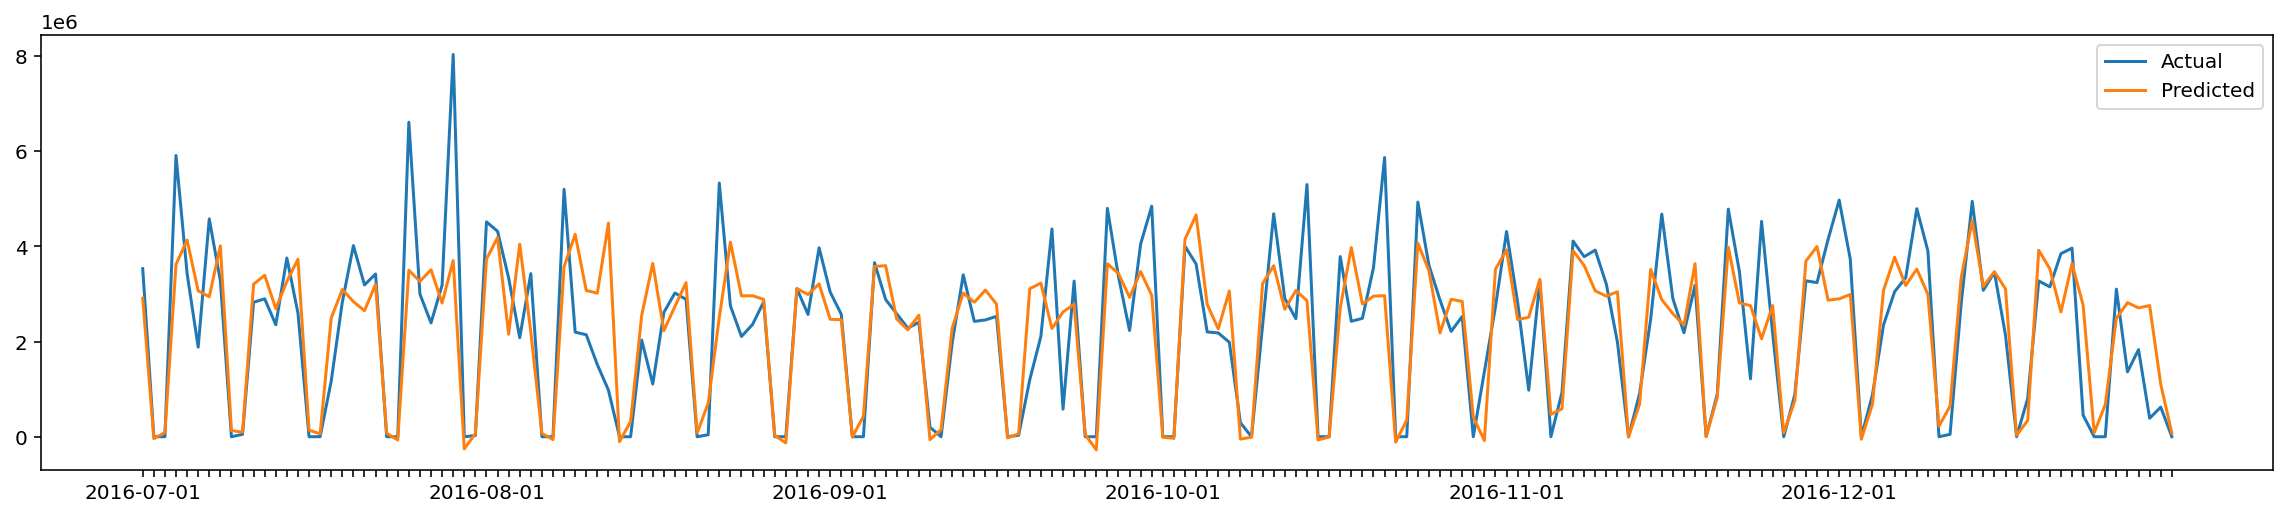

In [46]:
# 시각화
plt.figure(figsize=(20, 4))
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], cat_19[cat_19['date'] >= '2016-07-01']['order_demand'], label='Actual')
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], y_pred, label='Predicted')

labels = [item if item[-2:] == '01' else '' for item in sorted(day_list) if ((item[:4] == '2016') and (item[5:7] >= '07'))]
plt.xticks(cat_19[cat_19['date'] >= '2016-07-01']['date'], labels)
plt.legend()

plt.show();

### 3. 하이퍼 파라미터 튜닝

위에서 가장 rmse가 작았던 시간 feature를 사용하고 전체 데이터를 학습에 이용한 모델을 하이퍼 파라미터 튜닝을 하여 성능을 개선시켜보았다.

In [37]:
# eval set 생성
pre_processing_part = make_pipeline(
    SimpleImputer(),
    RobustScaler())

X_train_processing = pre_processing_part.fit_transform(X_train)
X_val_processing = pre_processing_part.transform(X_val)

eval_set = [(X_train_processing, y_train),
            (X_val_processing, y_val)]

In [ ]:
# 모델 생성
xgb_hyper = XGBRegressor(
    random_state=1,
    n_jobs=-1,
    objective='reg:squarederror')

# 사용할 하이퍼 파라미터
dists = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0, 0.01, 0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]}

# cv
cv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
reg_xgb_hyper = GridSearchCV(
    xgb_hyper, 
    param_grid=dists,
    cv=cv, 
    scoring='neg_root_mean_squared_error',
    verbose=0,
    n_jobs=-1
)

reg_xgb_hyper.fit(X_train_processing,
                  y_train,
                  eval_set = eval_set,
                  eval_metric='rmse',
                  early_stopping_rounds = 50);

In [39]:
# 결과 확인
print('best hyper-parameter: ', reg_xgb_hyper.best_params_)

best hyper-parameter:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3}


In [40]:
# cv 결과 확인
pd.DataFrame(reg_xgb_hyper.cv_results_).sort_values(by='rank_test_score').head().T

,530,50,290,410,170
mean_fit_time,0.284788,0.289708,0.283733,0.271973,0.281152
std_fit_time,0.041301,0.0414916,0.0300014,0.0599105,0.069175
mean_score_time,0.00175319,0.00187249,0.00161414,0.00169559,0.00170517
std_score_time,0.000492222,0.000497715,0.000443196,0.000388793,0.000409354
param_gamma,0.3,0,0.1,0.2,0.01
param_learning_rate,0.1,0.1,0.1,0.1,0.1
param_max_depth,3,3,3,3,3
param_min_child_weight,3,3,3,3,3
params,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept...","{'gamma': 0, 'learning_rate': 0.1, 'max_depth'...","{'gamma': 0.1, 'learning_rate': 0.1, 'max_dept...","{'gamma': 0.2, 'learning_rate': 0.1, 'max_dept...","{'gamma': 0.01, 'learning_rate': 0.1, 'max_dep..."
split0_test_score,-1.03079e+06,-1.03079e+06,-1.03079e+06,-1.03079e+06,-1.03079e+06


In [42]:
# 모델 저장
model_xgb_hyper = reg_xgb_hyper.best_estimator_

# 예측
y_pred = model_xgb_hyper.predict(X_val_processing)

# 결과 정리
print('mae :', round(mae(y_val, y_pred), 2))
print('rmse :', round(np.sqrt(mse(y_val, y_pred)), 2))

mae : 669591.5
rmse : 999821.2


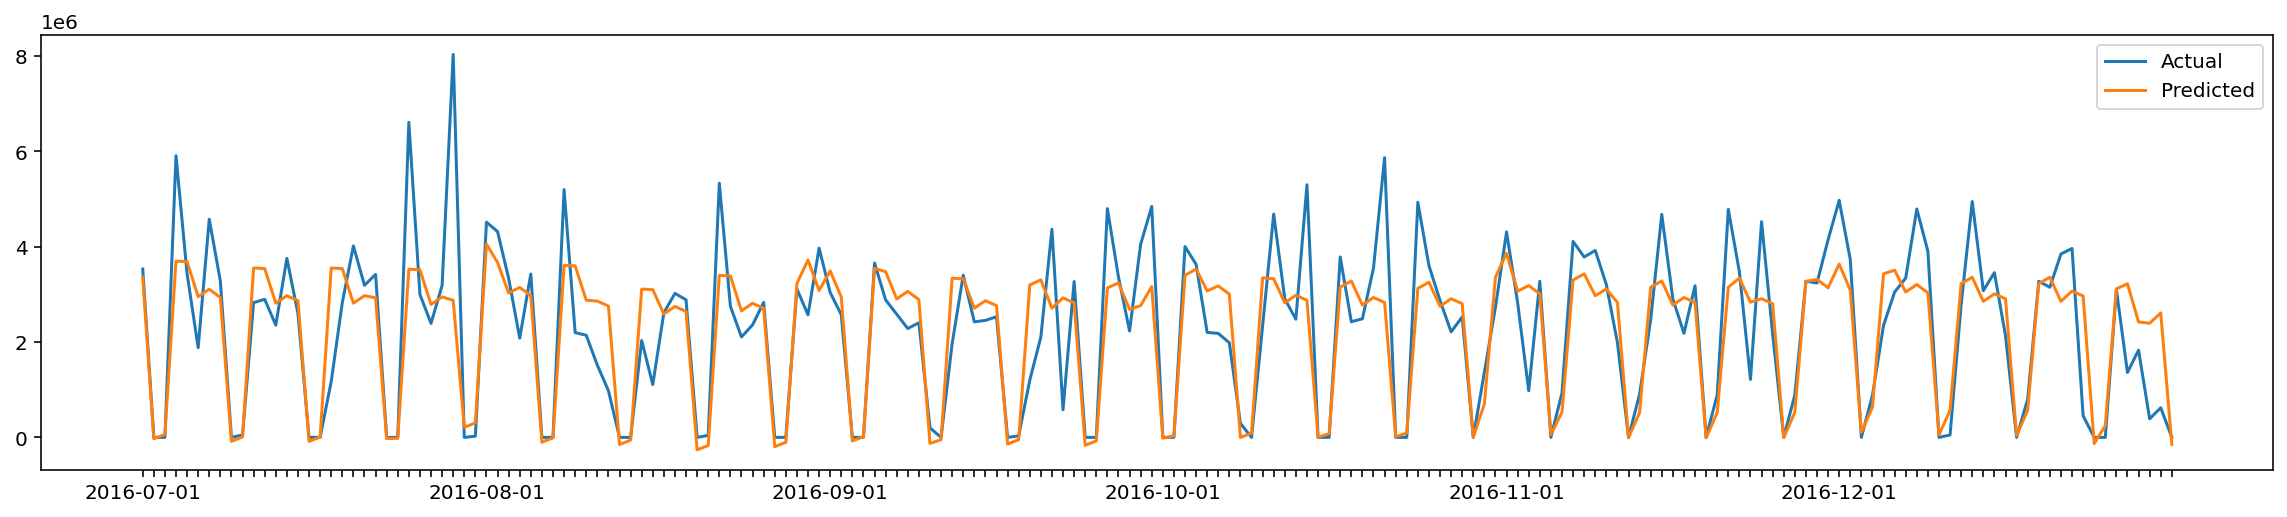

In [43]:
plt.figure(figsize=(20, 4))
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], cat_19[cat_19['date'] >= '2016-07-01']['order_demand'], label='Actual')
plt.plot(cat_19[cat_19['date'] >= '2016-07-01']['date'], y_pred, label='Predicted')

labels = [item if item[-2:] == '01' else '' for item in sorted(day_list) if ((item[:4] == '2016') and (item[5:7] >= '07'))]
plt.xticks(cat_19[cat_19['date'] >= '2016-07-01']['date'], labels)
plt.legend()

plt.show();

하이퍼 파라미터를 튜닝하기 전 모델의 validation data set에 대한 mae는 약 715,350이고, rmse는 약 1,019,237였다. 하이퍼 파라미터 튜닝 후에는 mae가 약 669,592이고, rmse는 약 999,821로 성능이 개선되었다. 이 값은 baseline이었던 ARIMA 모델의 mae(약 1,566,822)와 rmse(약 2,036,131)보다 작기 때문에 의미있는 모델이라고 할 수 있다.

### 4. 모델 저장

In [44]:
import pickle
import gzip

def save_as_pickle(data, file_name):
    
    with gzip.open(file_name, 'wb') as f:
        pickle.dump(data, f)

# 모델 저장
save_as_pickle(model_xgb_hyper, 'xgb_hyper_save.pickle')

### 5. 모델 해석

In [47]:
# feature 목록 저장하기
feature_names = X_train.columns

#### a. Feature Importance

In [49]:
# feature importance
feature_impt = pd.Series(model_xgb_hyper.feature_importances_, feature_names).sort_values(ascending=False)
feature_impt

day_of_week     0.870359
day             0.034312
week_of_year    0.033366
year            0.031619
month           0.030345
quarter         0.000000
dtype: float32

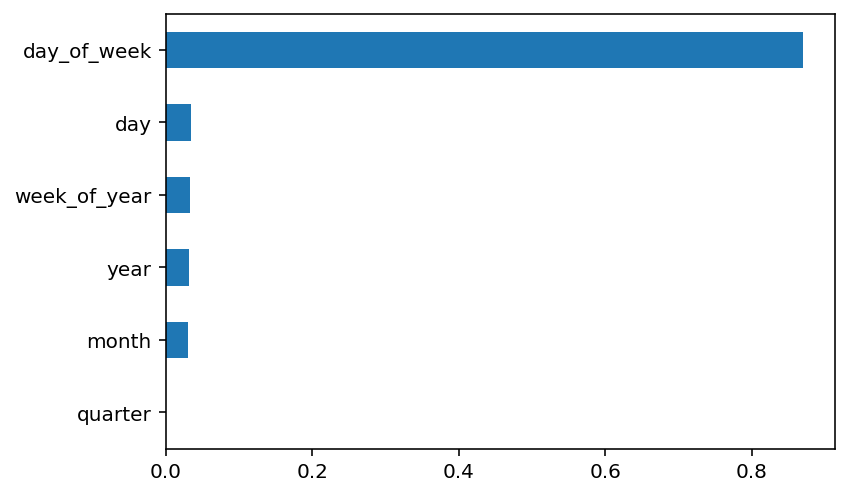

In [50]:
# 시각화
feature_impt.sort_values(ascending=True).plot.barh();

#### b. Permutation Importance

In [53]:
import eli5
from eli5.sklearn import PermutationImportance

In [57]:
# permuter 생성
permuter = PermutationImportance(
    model_xgb_hyper,
    scoring='neg_root_mean_squared_error',
    n_iter=3,
    random_state=1)

# permutation importance 계산
permuter.fit(X_val_processing, y_val)

# 상위 10개 확인
permutation_impt = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)
permutation_impt

day_of_week     1.221025e+06
week_of_year    3.572688e+04
day             2.020046e+04
month           3.634381e+03
quarter         0.000000e+00
year            0.000000e+00
dtype: float64

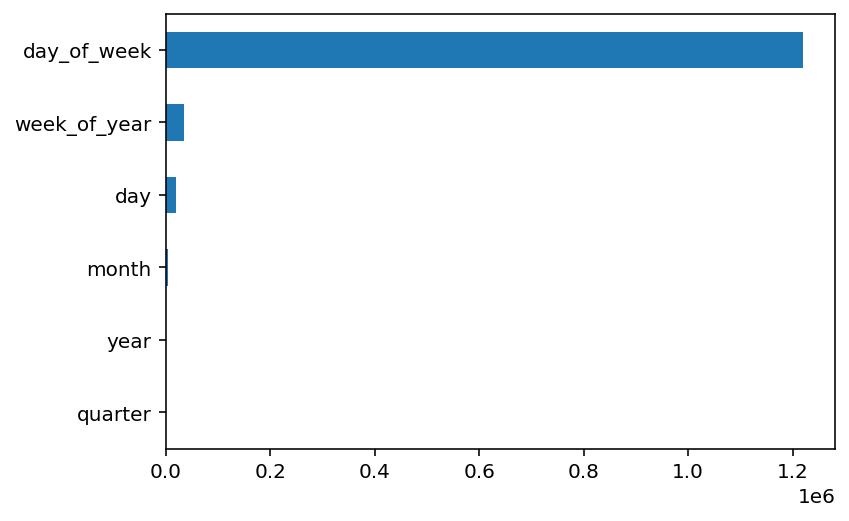

In [58]:
# 시각화
permutation_impt.sort_values(ascending=True).plot.barh();

Feature importance와 permutaion importance에서 모두 요일이 가장 중요한 feature로 나왔다. quarter는 가장 중요하지 않은 feature이다.